In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
words = open("Files/processed_names.txt", "r").read().splitlines()
words[:10]

['aelie',
 'darrellee',
 'barbra',
 'robsan',
 'leovanni',
 'haniyah',
 'jhazzryn',
 'tannistha',
 'sujata',
 'jairuz']

In [3]:
len(words)

30679

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Creating the dataset

In [10]:
block_size = 3  # context size for our neural network
X, Y = [], []
for w in words[:5]:  # This is an example for 5 words of the dataset only
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

aelie
... ---> a
..a ---> e
.ae ---> l
ael ---> i
eli ---> e
lie ---> .
darrellee
... ---> d
..d ---> a
.da ---> r
dar ---> r
arr ---> e
rre ---> l
rel ---> l
ell ---> e
lle ---> e
lee ---> .
barbra
... ---> b
..b ---> a
.ba ---> r
bar ---> b
arb ---> r
rbr ---> a
bra ---> .
robsan
... ---> r
..r ---> o
.ro ---> b
rob ---> s
obs ---> a
bsa ---> n
san ---> .
leovanni
... ---> l
..l ---> e
.le ---> o
leo ---> v
eov ---> a
ova ---> n
van ---> n
ann ---> i
nni ---> .


In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([39, 3]), torch.int64, torch.Size([39]), torch.int64)

#### We are going to embed each of the 27 characters into 2 dimensional space first

In [12]:
C = torch.randn((27, 2))
C

tensor([[-8.8412e-01,  1.5686e+00],
        [ 2.2627e+00, -7.2440e-01],
        [ 1.3581e+00,  9.4889e-01],
        [-1.2194e+00, -9.3806e-01],
        [ 1.1288e+00,  1.3496e+00],
        [-2.3351e+00, -3.2683e-02],
        [ 1.4459e+00, -1.4911e+00],
        [ 2.6577e-01,  1.3736e-01],
        [-1.0707e+00, -4.5795e-01],
        [ 5.0178e-02, -8.3965e-01],
        [ 4.7376e-01, -1.1218e+00],
        [ 7.6823e-01, -2.5217e-01],
        [ 3.1753e-01,  6.4720e-01],
        [-2.1273e-03,  8.3613e-01],
        [-1.1382e+00, -2.4189e-01],
        [ 4.7322e-01, -4.2511e-01],
        [ 2.5273e-01, -2.4777e-01],
        [-1.1552e+00,  4.4664e-01],
        [ 9.5101e-01,  3.8824e-01],
        [ 1.0722e+00, -3.7033e-01],
        [ 6.8207e-01,  1.0055e+00],
        [ 1.6213e+00,  4.0314e-01],
        [ 5.1092e-02,  6.1860e-01],
        [ 4.6893e-01, -1.2941e+00],
        [ 1.6941e+00,  1.4478e+00],
        [ 1.8861e+00, -1.5764e-01],
        [ 9.4811e-01, -1.4173e+00]])

In [24]:
# Say to embed integer 5
C[5]
# Or 
# F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-2.3351, -0.0327])

In [27]:
# To get embedding of all elements of X
emb = C[X]
emb.shape

torch.Size([39, 3, 2])

In [44]:
# First layer of neurons
W1 = torch.randn((6, 100))  # each example has shape (1, 3, 2) which has 6 elements and here we consider 100 neurons
b1 = torch.randn((100,))
# but first, we need to transform emb to have the shape (39, 6)
emb.view(-1, 6)  # this is efficient than below options because it just manipulatest the storage of tensor
# or
# torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1).shape
# or 
# torch.cat(torch.unbind(emb, 1), 1).shape # this code generalizes to any block_size

tensor([[-0.8841,  1.5686, -0.8841,  1.5686, -0.8841,  1.5686],
        [-0.8841,  1.5686, -0.8841,  1.5686,  2.2627, -0.7244],
        [-0.8841,  1.5686,  2.2627, -0.7244, -2.3351, -0.0327],
        [ 2.2627, -0.7244, -2.3351, -0.0327,  0.3175,  0.6472],
        [-2.3351, -0.0327,  0.3175,  0.6472,  0.0502, -0.8396],
        [ 0.3175,  0.6472,  0.0502, -0.8396, -2.3351, -0.0327],
        [-0.8841,  1.5686, -0.8841,  1.5686, -0.8841,  1.5686],
        [-0.8841,  1.5686, -0.8841,  1.5686,  1.1288,  1.3496],
        [-0.8841,  1.5686,  1.1288,  1.3496,  2.2627, -0.7244],
        [ 1.1288,  1.3496,  2.2627, -0.7244,  0.9510,  0.3882],
        [ 2.2627, -0.7244,  0.9510,  0.3882,  0.9510,  0.3882],
        [ 0.9510,  0.3882,  0.9510,  0.3882, -2.3351, -0.0327],
        [ 0.9510,  0.3882, -2.3351, -0.0327,  0.3175,  0.6472],
        [-2.3351, -0.0327,  0.3175,  0.6472,  0.3175,  0.6472],
        [ 0.3175,  0.6472,  0.3175,  0.6472, -2.3351, -0.0327],
        [ 0.3175,  0.6472, -2.3351, -0.0

In [47]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-1.0000, -0.0782, -0.9959,  ...,  1.0000, -0.9652,  0.4611],
        [-0.9117, -0.9996, -0.9134,  ...,  0.9428, -1.0000, -0.3235],
        [ 0.9969,  0.6905, -0.9992,  ...,  0.9994,  0.7704,  0.9948],
        ...,
        [ 0.9991, -0.5258, -0.9598,  ...,  0.8469,  0.9357,  0.9896],
        [ 0.8583,  0.9941,  0.9999,  ...,  0.9994,  1.0000,  0.9900],
        [ 0.9994, -0.1813, -0.9960,  ..., -0.6858, -0.2254, -0.9449]])

In [48]:
h.shape

torch.Size([39, 100])

In [49]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27,))

In [50]:
logits = h @ W2 + b2
logits.shape

torch.Size([39, 27])

In [51]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
probs.shape

torch.Size([39, 27])

In [54]:
Y.shape

torch.Size([39])

In [57]:
probs[0, 1]

tensor(1.3210e-07)

In [65]:
# nll = torch.tensor([probs[i, Y[i]] for i in torch.arange(Y.shape[0])]).log().mean().neg()
# or alternatively
nll = probs[torch.arange(Y.shape[0]), Y].log().mean().neg()  # nll denotes negative log likelihood 

### Summarising the network architecture

In [81]:
block_size = 3  # context size for our neural network
X, Y = [], []
for w in words:  
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [82]:
X.shape, Y.shape

(torch.Size([229043, 3]), torch.Size([229043]))

In [228]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100,), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [84]:
sum(p.nelement() for p in parameters)  # total number of parameters

3481

In [85]:
for i in range(100):    
    # Forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Y)  # more efficient because it uses fused kernels, simplified expression during backpropagation
    print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

Iteration 1 , Loss: 19.220617294311523
Iteration 2 , Loss: 16.93214225769043
Iteration 3 , Loss: 15.696292877197266
Iteration 4 , Loss: 14.784036636352539
Iteration 5 , Loss: 13.97189712524414
Iteration 6 , Loss: 13.240312576293945
Iteration 7 , Loss: 12.584552764892578
Iteration 8 , Loss: 12.00675106048584
Iteration 9 , Loss: 11.51274585723877
Iteration 10 , Loss: 11.109825134277344
Iteration 11 , Loss: 10.781571388244629
Iteration 12 , Loss: 10.492368698120117
Iteration 13 , Loss: 10.224698066711426
Iteration 14 , Loss: 9.972886085510254
Iteration 15 , Loss: 9.73393726348877
Iteration 16 , Loss: 9.505840301513672
Iteration 17 , Loss: 9.287216186523438
Iteration 18 , Loss: 9.077119827270508
Iteration 19 , Loss: 8.874870300292969
Iteration 20 , Loss: 8.67996597290039
Iteration 21 , Loss: 8.492053031921387
Iteration 22 , Loss: 8.310914039611816
Iteration 23 , Loss: 8.136455535888672
Iteration 24 , Loss: 7.968682765960693
Iteration 25 , Loss: 7.807672500610352
Iteration 26 , Loss: 7.6535

In [86]:
# Running it further
for i in range(100):    
    # Forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Y)  # more efficient because it uses fused kernels, simplified expression during backpropagation
    print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

Iteration 1 , Loss: 3.769014596939087
Iteration 2 , Loss: 3.753577709197998
Iteration 3 , Loss: 3.738506555557251
Iteration 4 , Loss: 3.7237908840179443
Iteration 5 , Loss: 3.709420919418335
Iteration 6 , Loss: 3.6953864097595215
Iteration 7 , Loss: 3.681678533554077
Iteration 8 , Loss: 3.6682872772216797
Iteration 9 , Loss: 3.655202865600586
Iteration 10 , Loss: 3.6424176692962646
Iteration 11 , Loss: 3.6299211978912354
Iteration 12 , Loss: 3.6177053451538086
Iteration 13 , Loss: 3.6057612895965576
Iteration 14 , Loss: 3.5940802097320557
Iteration 15 , Loss: 3.5826542377471924
Iteration 16 , Loss: 3.571474552154541
Iteration 17 , Loss: 3.5605337619781494
Iteration 18 , Loss: 3.549823045730591
Iteration 19 , Loss: 3.5393362045288086
Iteration 20 , Loss: 3.529064416885376
Iteration 21 , Loss: 3.5190012454986572
Iteration 22 , Loss: 3.5091400146484375
Iteration 23 , Loss: 3.4994728565216064
Iteration 24 , Loss: 3.489994525909424
Iteration 25 , Loss: 3.4806978702545166
Iteration 26 , Loss

In [87]:
# The above code is run twice and we find that the each iteration takes longer time, so we use minibatch instead

In [257]:
# Resetting parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn((100,), generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [138]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
# lrs

In [135]:
lri = []  # contains the exponent of learning rate
lossi = []

for i in range(1000):    
    # Construct minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Y[ix])  # more efficient because it uses fused kernels, simplified expression during backpropagation
    print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # Store learning rate and loss
    lri.append(lre[i])
    lossi.append(loss.item())
    
# print(loss.item())

Iteration 1 , Loss: 19.642507553100586
Iteration 2 , Loss: 21.000919342041016
Iteration 3 , Loss: 20.826698303222656
Iteration 4 , Loss: 19.08496856689453
Iteration 5 , Loss: 20.49187469482422
Iteration 6 , Loss: 21.732582092285156
Iteration 7 , Loss: 19.02778434753418
Iteration 8 , Loss: 20.09446144104004
Iteration 9 , Loss: 14.72089958190918
Iteration 10 , Loss: 18.33893394470215
Iteration 11 , Loss: 16.047670364379883
Iteration 12 , Loss: 19.714208602905273
Iteration 13 , Loss: 16.673229217529297
Iteration 14 , Loss: 18.580760955810547
Iteration 15 , Loss: 15.219694137573242
Iteration 16 , Loss: 16.35300636291504
Iteration 17 , Loss: 19.148942947387695
Iteration 18 , Loss: 16.74610710144043
Iteration 19 , Loss: 19.312585830688477
Iteration 20 , Loss: 15.731391906738281
Iteration 21 , Loss: 17.590639114379883
Iteration 22 , Loss: 19.236602783203125
Iteration 23 , Loss: 18.257795333862305
Iteration 24 , Loss: 18.167966842651367
Iteration 25 , Loss: 15.006281852722168
Iteration 26 , Lo

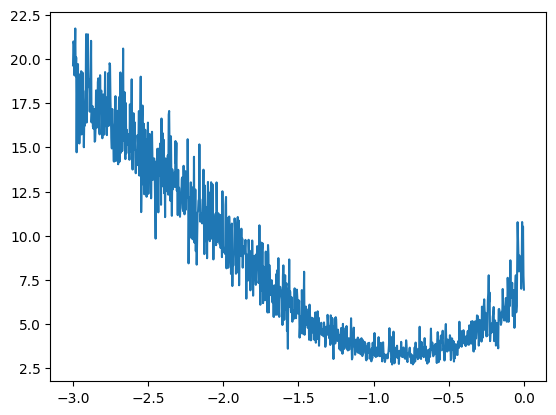

In [136]:
plt.plot(lri, lossi)

In [258]:
# We find that the best loss is for learning rate exponent around -1.0, so we set lr = 10**-1.0 and we can run more steps.
for i in range(10000):    
    # Construct minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Y[ix])  # more efficient because it uses fused kernels, simplified expression during backpropagation
    # print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 10**-1.0
    for p in parameters:
        p.data += -lr * p.grad
    
    # Store learning rate and loss
    # lri.append(lre[i])
    # lossi.append(loss.item())
    
print(loss.item())

2.3762383460998535


In [259]:
# Decaying the learning rate and running more steps
for i in range(10000):    
    # Construct minibatch
    ix = torch.randint(0, X.shape[0], (32,))

    # Forward pass
    emb = C[X[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Y[ix])  # more efficient because it uses fused kernels, simplified expression during backpropagation
    # print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 10**-2.0
    for p in parameters:
        p.data += -lr * p.grad

    # Store learning rate and loss
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.563948154449463


In [260]:
emb = C[X]  
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.437300443649292

In [261]:
# This is already better than what we have achieved using the model based on our intuition (bigram model)

### Adding train, test and validation split to avoid overfitting
- #### Train split is used to obtain the parameters, validation split for choosing the best hyperparameters, train split for evaluating the model

In [262]:
# build the dataset
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:  
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])  # Same as validation set
Xte, Yte = build_dataset(words[n2:])


torch.Size([183258, 3]) torch.Size([183258])
torch.Size([22861, 3]) torch.Size([22861])
torch.Size([22924, 3]) torch.Size([22924])


In [263]:
Xtr.shape, Ytr.shape

(torch.Size([183258, 3]), torch.Size([183258]))

In [317]:
# Resetting parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 300), generator=g, requires_grad=True)
b1 = torch.randn((300,), generator=g, requires_grad=True)
W2 = torch.randn((300, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [318]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [319]:
lri = []  # contains the exponent of learning rate
lossi = []

for i in range(1000):    
    # Construct minibatch
    ix = torch.randint(0, Xdev.shape[0], (256,))
    
    # Forward pass
    emb = C[Xdev[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Ydev[ix])  # more efficient because it uses fused kernels, simplified expression during backpropagation
    print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # Store learning rate and loss
    lri.append(lre[i])
    lossi.append(loss.item())
    
# print(loss.item())

Iteration 1 , Loss: 19.796716690063477
Iteration 2 , Loss: 18.367109298706055
Iteration 3 , Loss: 18.128002166748047
Iteration 4 , Loss: 16.520008087158203
Iteration 5 , Loss: 15.858794212341309
Iteration 6 , Loss: 15.133967399597168
Iteration 7 , Loss: 15.796759605407715
Iteration 8 , Loss: 15.036417961120605
Iteration 9 , Loss: 14.380845069885254
Iteration 10 , Loss: 13.066110610961914
Iteration 11 , Loss: 12.96157455444336
Iteration 12 , Loss: 13.60091495513916
Iteration 13 , Loss: 13.810588836669922
Iteration 14 , Loss: 13.782127380371094
Iteration 15 , Loss: 12.475520133972168
Iteration 16 , Loss: 13.584747314453125
Iteration 17 , Loss: 12.48475456237793
Iteration 18 , Loss: 11.417655944824219
Iteration 19 , Loss: 12.844965934753418
Iteration 20 , Loss: 12.340853691101074
Iteration 21 , Loss: 13.998640060424805
Iteration 22 , Loss: 13.150482177734375
Iteration 23 , Loss: 12.71766471862793
Iteration 24 , Loss: 11.8101806640625
Iteration 25 , Loss: 13.099871635437012
Iteration 26 , 

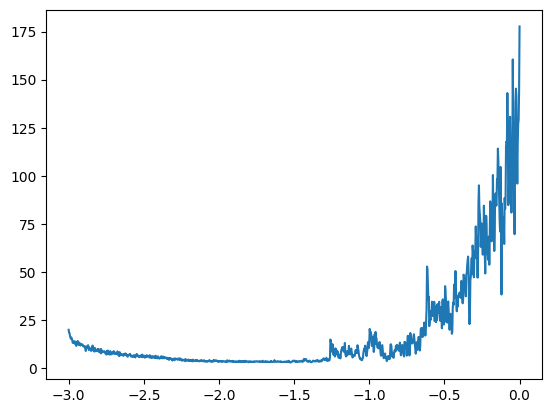

In [320]:
plt.plot(lri, lossi)

In [329]:
# We find that the best loss is for learning rate exponent around -1.4, so we set lr = 10**-1.4 and we can run more steps.
lri = []
stepi = []
lossi = []

for i in range(10000):    
    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (256,))
    
    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Ytr[ix])  # more efficient because it uses fused kernels, simplified expression during backpropagation
    # print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 10**-4
    for p in parameters:
        p.data += -lr * p.grad
    
    # Store learning rate and loss
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())
    
print(loss.item())

2.8432483673095703


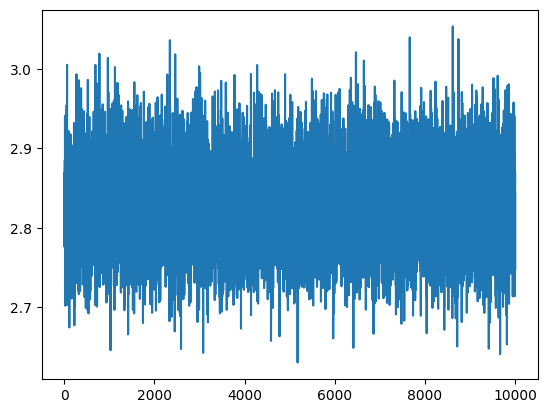

In [330]:
plt.plot(stepi, lossi)

In [331]:
emb = C[Xte]  
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss.item()

2.8290841579437256

In [332]:
## Our dataset isn't very good, so the model isn't trained well in just 2 dimensions. We need to add more dimensions for embedding.

In [342]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 200), generator=g, requires_grad=True)
b1 = torch.randn((200,), generator=g, requires_grad=True)
W2 = torch.randn((200, 27), generator=g, requires_grad=True)
b2 = torch.randn((27,), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [343]:
lri = []
stepi = []
lossi = []

In [347]:
# We find that the best loss is for learning rate exponent around -1.4, so we set lr = 10**-1.4 and we can run more steps.
for i in range(50000):    
    # Construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]]  # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = prob[torch.arange(Y.shape[0]), Y].log().mean().neg()  # can be replaced by F.cross_entropy for softmax 
    loss = F.cross_entropy(logits, Ytr[ix])  # more efficient because it uses fused kernels, simplified expression during backpropagation
    # print("Iteration", i+1, ", Loss:", loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 10**-3
    for p in parameters:
        p.data += -lr * p.grad
    
    # Store learning rate and loss
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
    
print(loss.item())

2.982537031173706


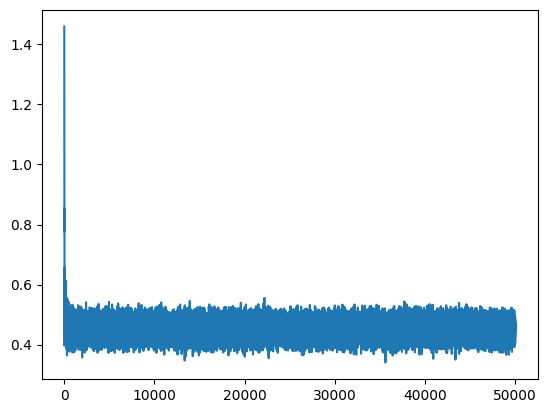

In [348]:
plt.plot(stepi, lossi)

In [349]:
emb = C[Xte]  
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss.item()

2.8296139240264893